In [1]:
import tensorflow as tf
import keras
from draw_candle_image import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta.trend
from ta import add_all_ta_features
from ta.utils import dropna
import ta
import ta.momentum
import json
from common_train_utils import *
from functools import partial
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
import tensorflow_docs.modeling
from model_code import *
import os

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmptko99y45\tensorboard_logs


In [4]:
dataset_folder = "./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024"

In [5]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [6]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

folder: bullish_engulfing, 		 total: 19 images
folder: bearish_engulfing, 		 total: 15 images
folder: star_doji, 		 total: 0 images
folder: dragonfly_doji, 		 total: 0 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 14 images
folder: evening_star, 		 total: 14 images
folder: hammer, 		 total: 0 images
folder: inverted_hammer, 		 total: 0 images
folder: harami_down, 		 total: 88 images
folder: harami_up, 		 total: 72 images
folder: tweezer_top, 		 total: 14 images
folder: tweezer_bottom, 		 total: 14 images
folder: marubozu, 		 total: 0 images
folder: spin, 		 total: 21 images
folder: next_3_day_up, 		 total: 44 images
folder: next_3_day_down, 		 total: 42 images


In [7]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

folder: bullish_engulfing, 		 total: 62 images
folder: bearish_engulfing, 		 total: 70 images
folder: star_doji, 		 total: 20 images
folder: dragonfly_doji, 		 total: 6 images
folder: gravestone_doji, 		 total: 11 images
folder: morning_star, 		 total: 57 images
folder: evening_star, 		 total: 54 images
folder: hammer, 		 total: 19 images
folder: inverted_hammer, 		 total: 6 images
folder: harami_down, 		 total: 368 images
folder: harami_up, 		 total: 328 images
folder: tweezer_top, 		 total: 41 images
folder: tweezer_bottom, 		 total: 37 images
folder: marubozu, 		 total: 46 images
folder: spin, 		 total: 88 images
folder: next_3_day_up, 		 total: 237 images
folder: next_3_day_down, 		 total: 168 images


In [8]:
def model_5_biLSTM(image_shape, days_result):
    model = keras.Sequential([
        keras.layers.Input(image_shape),
        keras.layers.Conv2D(8, (2, 2), activation='relu'),
        keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        keras.layers.Conv2D(8, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.1),  # Giảm tỷ lệ Dropout
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.RepeatVector(days_result),
        keras.layers.LSTM(64, activation='tanh', return_sequences=True),
        keras.layers.Dropout(0.1),
        keras.layers.LSTM(64, activation='tanh', return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(2))
    ])
    
    return model, "model_5_biLSTM"

In [9]:
for images_train, labels_train, dates_train in dataset_train.take(1):
    break
image_shape = tuple(images_train.shape)
model, model_name = model_5_biLSTM(image_shape, days_result)

In [10]:
batch_size = 64
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{dataset_folder}"
name_folder_save_metrics = f"sizes/{model_name}_{dataset_folder}"
max_epochs = 100
metric_name = "mean_absolute_error"
metric_object = keras.metrics.MeanAbsoluteError(name=metric_name)
val_loss_metric_to_stop = 1.3199
start_learning_rate = 0.01
shuffle_buffer = 300
number_epochs_to_decrease_lr = 30
number_epochs_to_wait = 10

In [11]:
model_name

'model_5_biLSTM'

In [12]:
STEPS_PER_EPOCH

26

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 286, 286, 8)    │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 143, 143, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 141, 141, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 70, 70, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,254,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 2)           │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,162 (5.01 MB)

 Trainable params: 1,314,162 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
(total_data_train, total_data_test)

(1618, 357)

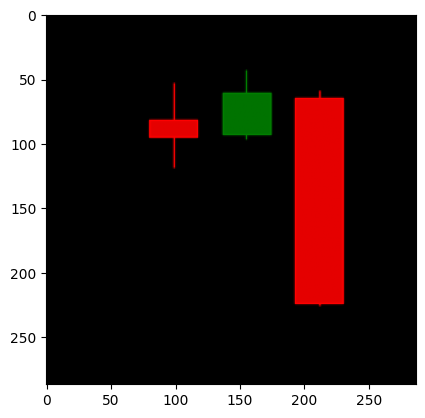

In [15]:
plt.imshow(images_train)

In [16]:
output = model.layers[1](tf.expand_dims(images_train, axis=0))[0]

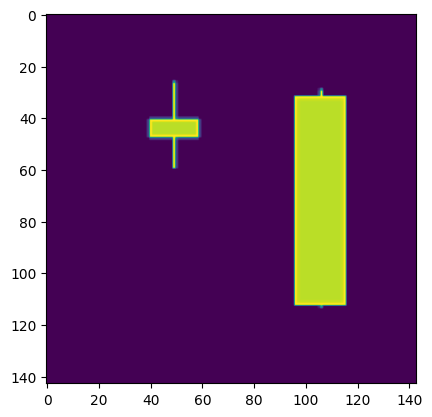

In [17]:
plt.imshow(output[:,:, 0])

In [18]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(get_open_close_prices_percent_of_last_days_result, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [19]:
(len(dataset_train_3), len(dataset_test_3))

(26, 6)

In [20]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True

In [21]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)


def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_to_stop, metric_name),
        keras.callbacks.EarlyStopping(monitor=f'val_{metric_name}', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_object,
    ],
)


In [22]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_name, number_epochs_to_wait)
    )

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 10.0727 - mean_absolute_error: 1.8747
Epoch: 0, loss:10.2478,  mean_absolute_error:1.8770,  val_loss:4.3160,  val_mean_absolute_error:1.2879,  
.
Đạt target loss = 1.3199, dừng training tại epoch 1
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - loss: 10.0792 - mean_absolute_error: 1.8748 - val_loss: 4.3160 - val_mean_absolute_error: 1.2879


In [23]:
def save_dataset(prefix, dataset_test, model_name):
    prefix_of_folder = prefix
    path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        prefix_of_folder = prefix_of_folder + "_1"
        path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    tf.data.Dataset.save(dataset_test, path_save)

In [24]:
def save_model(model: keras.Sequential, model_name):
    path_save = f"{dataset_folder}/model_save/{model_name}.keras"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        model_name = model_name + "_1"
        path_save = f"{dataset_folder}/model_save/{model_name}.keras"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    model.save(path_save)
    return os.path.basename(path_save).split('.')[0]

In [25]:
model_name_saved = save_model(model, model_name)

-- ./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024/model_save/model_5_biLSTM.keras already exists
-- Change to ./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024/model_save/model_5_biLSTM_1.keras
-- ./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024/model_save/model_5_biLSTM_1.keras already exists
-- Change to ./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024/model_save/model_5_biLSTM_1_1.keras
-- ./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024/model_save/model_5_biLSTM_1_1.keras already exists
-- Change to ./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024/model_save/model_5_biLSTM_1_1_1.keras
Save to ./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024/model_save/model_5_biLSTM_1_1_1.keras


In [26]:
size_histories = {}

In [27]:
size_histories[name_sub_folder_save_metrics] = history 

d:\code\selenium\.venv\lib\site-packages\tensorflow_docs\plots\__init__.py:111: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(


(0.0, 2.0)

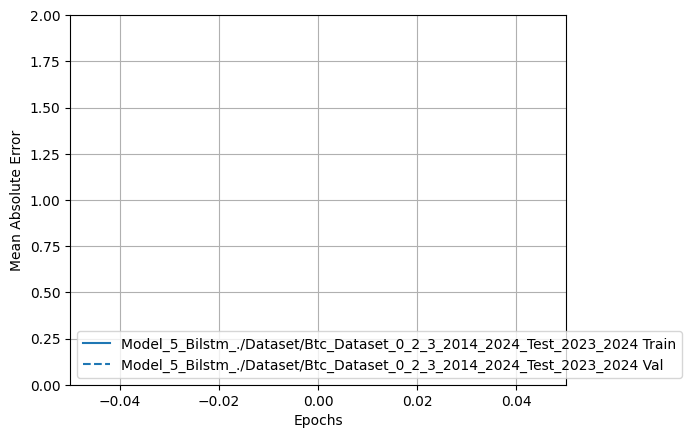

In [28]:
plotter = tfdocs.plots.HistoryPlotter(metric=metric_name, smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,2])

In [29]:
train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')

In [30]:
for x_train, y_train, date_train in train_dataset.take(2):
    pass
for x_test, y_test, date_test in test_dataset.take(2):
    pass

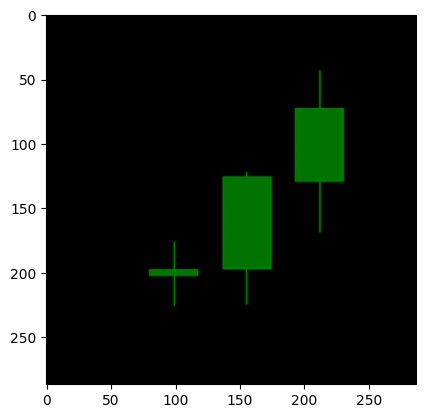

In [31]:
plt.imshow(x_train)

In [32]:
y_train

<tf.Tensor: shape=(6, 4), dtype=float64, numpy=
array([[367.19100952, 361.36199951, 362.29901123, 355.95098877],
       [379.43301392, 362.60598755, 378.54901123, 356.14401245],
       [397.22601318, 377.92098999, 390.41400146, 368.89700317],
       [411.69799805, 391.69198608, 400.86999512, 391.32400513],
       [402.22698975, 400.95498657, 394.77301025, 388.76599121],
       [398.80700684, 394.51800537, 382.55599976, 373.07000732]])>

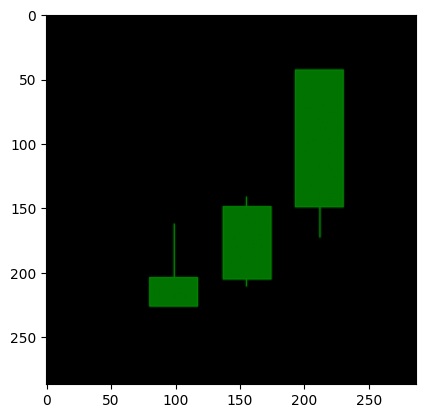

In [33]:
plt.imshow(x_test)

In [34]:
y_test

<tf.Tensor: shape=(6, 4), dtype=float64, numpy=
array([[17389.95703125, 17093.9921875 , 17196.5546875 , 17093.9921875 ],
       [17484.72070312, 17192.94921875, 17446.29296875, 17162.99023438],
       [17934.89648438, 17446.359375  , 17934.89648438, 17337.99414062],
       [19030.08789062, 18117.59375   , 18869.58789062, 17995.203125  ],
       [19964.32226562, 18868.90625   , 19909.57421875, 18753.1640625 ],
       [21075.14257812, 19910.53710938, 20976.29882812, 19907.828125  ]])>

In [35]:
model_name_saved

'model_5_biLSTM_1_1_1'

In [36]:
dataset_folder

'./dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024'